In [116]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from scipy.integrate import odeint, solve_ivp

from dataset import Dataset
from PINN import PINN, get_loss

In [126]:
# Read excel with multiple sheets
xls = pd.ExcelFile('data/correct_data.xlsx')
df = xls.parse('BR01')
columns = ['Time', 'Biomass', 'Glucose']
df.columns = columns
df['Biomass'].iloc[0] = 1e-6

t_train = df['Time'].values
u_train = df[['Biomass', 'Glucose']].values

In [127]:
pinn = PINN(1, 2, T_START=df['Time'].min(), T_END=df['Time'].max())
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [139]:
# Train data to tensor
ts_train = torch.tensor(t_train, requires_grad=True).float().view(-1,1)
us_train = torch.tensor(u_train, requires_grad=True).float()

EPOCHS = 5000
LOSS = []
for epoch in range(EPOCHS):
    u_pred = pinn(ts_train)
    residual_pred = get_loss(pinn)
    loss = criterion(u_pred, us_train)
    loss += 0.5*residual_pred
    LOSS.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}, ODE Loss: {torch.mean(residual_pred).item()}')
        print(f'mu_max: {pinn.mu_max.item()}, Km: {pinn.Km.item()}, Y_XS: {pinn.Y_XS.item()}')

Epoch: 0, Loss: 21.167417526245117, ODE Loss: 0.005754849873483181
mu_max: 0.4999000132083893, Km: 0.5001000165939331, Y_XS: 0.5001000165939331
Epoch: 500, Loss: 3.776005506515503, ODE Loss: 0.5345706939697266
mu_max: 0.43851152062416077, Km: 0.5466159582138062, Y_XS: 0.5580966472625732
Epoch: 1000, Loss: 1.0743145942687988, ODE Loss: 0.5376821756362915
mu_max: 0.42473742365837097, Km: 0.5697889924049377, Y_XS: 0.5568761229515076
Epoch: 1500, Loss: 0.7476022243499756, ODE Loss: 0.42007526755332947
mu_max: 0.46530216932296753, Km: 0.5805871486663818, Y_XS: 0.4976418614387512
Epoch: 2000, Loss: 0.5262555480003357, ODE Loss: 0.2778262495994568
mu_max: 0.5011881589889526, Km: 0.6145662665367126, Y_XS: 0.44640326499938965
Epoch: 2500, Loss: 0.36392444372177124, ODE Loss: 0.17174427211284637
mu_max: 0.5319643616676331, Km: 0.6653380990028381, Y_XS: 0.40462377667427063
Epoch: 3000, Loss: 0.24769620597362518, ODE Loss: 0.10086900740861893
mu_max: 0.5612165331840515, Km: 0.7159984111785889, Y_X

mu_max: 0.6994684338569641, Km: 0.6941318511962891, Y_XS: 0.3622592091560364


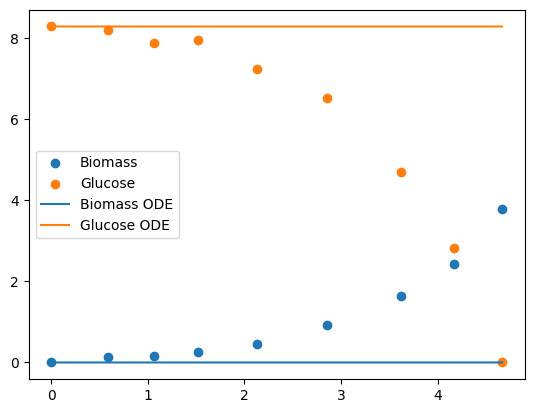

In [147]:
from scipy.integrate import odeint, solve_ivp

def ode_func(y, t, mu_max, Km, Y_XS):
    X, S = y
    mu = mu_max*S/(Km + S)
    dXdt = mu*X
    dSdt = -1/Y_XS*dXdt
    return [dXdt, dSdt]

# solve ODE
mu_max = pinn.mu_max.item()
Km = pinn.Km.item()
Y_XS = pinn.Y_XS.item()
print(f'mu_max: {mu_max}, Km: {Km}, Y_XS: {Y_XS}')

y0 = [u_train[0,0], u_train[0,1]]
sol = odeint(ode_func, y0, t_train, args=(mu_max, Km, Y_XS))

# Plot
plt.figure()
plt.scatter(t_train, u_train[:,0], label='Biomass')
plt.scatter(t_train, u_train[:,1], label='Glucose')
plt.plot(t_train, sol[:,0], label='Biomass ODE')
plt.plot(t_train, sol[:,1], label='Glucose ODE')
plt.legend()
plt.show()